In [1]:
from pathlib import Path
import json
from modules.data_processing import *
from datasets import Dataset
from typing import List, Dict, Tuple
import torch
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
import numpy as np
from datasets import load_from_disk

/home/gaye/miniconda3/envs/vt2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data_splits(dataset_key: str, split_file_name: str) -> dict[list]:
    path_split_file: Path = Path(f'vrdu2/{dataset_key}/few_shot-splits/prompts/{split_file_name}')
    
    with open(path_split_file, 'r', encoding='utf-8') as file:
        return json.load(file)

def get_labels_and_splits(dataset_key: str, split_file_name: str) -> tuple[list, dict, dict, dict]:
    data_splits: dict = load_data_splits(dataset_key, split_file_name)

    dataset_splits: dict = {
        "train_split": data_splits['train'],
        "test_split": data_splits['test']
    }

    label_list = ['O']
    labels: list = list(data_splits['train_entity_number_dict'].keys())
    for label in labels:
        label_list.append(f'B-{label.upper()}')
        label_list.append(f'I-{label.upper()}')
    id2label: dict = {k: v for k, v in enumerate(label_list)}
    label2id: dict = {v: k for k, v in enumerate(label_list)}

    return label_list, id2label, label2id, dataset_splits


In [3]:
PROJECT_ROOT = 'vrdu2/'
split_file_name = 'FARA-lv3-Short-Form-combined.json'  # Update the path to where your split files are located
dataset_key= 'registration-form'
path_extraction_folder = 'layoutlmv3_outputs/deneme-2/FARA-lv3-Short-Form-combined'
path_extraction_folder_valid = 'layoutlmv3_outputs/FARA-lv3-unk_Short-Form-train_10-test_300-valid_100-SD_0'

label_list, id2label, label2id, dataset_splits = get_labels_and_splits(dataset_key, split_file_name)

In [4]:
label_list

['O',
 'B-FILE_DATE',
 'I-FILE_DATE',
 'B-FOREIGN_PRINCIPLE_NAME',
 'I-FOREIGN_PRINCIPLE_NAME',
 'B-REGISTRANT_NAME',
 'I-REGISTRANT_NAME',
 'B-REGISTRATION_NUM',
 'I-REGISTRATION_NUM',
 'B-SIGNER_NAME',
 'I-SIGNER_NAME',
 'B-SIGNER_TITLE',
 'I-SIGNER_TITLE']

In [5]:
id2label

{0: 'O',
 1: 'B-FILE_DATE',
 2: 'I-FILE_DATE',
 3: 'B-FOREIGN_PRINCIPLE_NAME',
 4: 'I-FOREIGN_PRINCIPLE_NAME',
 5: 'B-REGISTRANT_NAME',
 6: 'I-REGISTRANT_NAME',
 7: 'B-REGISTRATION_NUM',
 8: 'I-REGISTRATION_NUM',
 9: 'B-SIGNER_NAME',
 10: 'I-SIGNER_NAME',
 11: 'B-SIGNER_TITLE',
 12: 'I-SIGNER_TITLE'}

In [4]:
import json
import gzip
from pathlib import Path
import pymupdf
from PIL import Image  # Import the Image class from the PIL library
import io 
import subprocess

def load_dataset_item(dataset_key: str) -> list[dict]:
    """
    Loads dataset items from a single compressed .jsonl.gz file.
    
    Args:
        dataset_key (str): The key used to locate the specific dataset folder.

    Returns:
        list[dict]: A list of dictionaries, each representing an individual dataset item with 
                    fields like 'filename', 'ocr', and 'annotations'.
    """
    dataset_items = []
    path_to_file = Path(f"{PROJECT_ROOT}/{dataset_key}/main/dataset.jsonl.gz")

    # Open and read the compressed .jsonl.gz file line-by-line
    with gzip.open(path_to_file, 'rt', encoding='utf-8') as file:
        for line in file:
            item_data = json.loads(line)  # Each line is a JSON object
            dataset_items.append(item_data)

    return dataset_items


In [7]:
def prepare_dataset(dataset_key: str, path_extraction_folder: Path, data_splits: dict, label2id: dict[str: int],
                    id2label: dict[int: str]) -> tuple[Dataset, Dataset, Dataset]:
    processed_files = set()
    
    def _unnormalize_bbox_for_layoutlmv3(bbox: list[int, float], factor: int = 1000) -> list[float]:
        x_min: float = bbox[1]
        y_min: float = bbox[2]
        x_max: float = bbox[3]
        y_max: float = bbox[4]

        return [
            x_min * factor,
            y_min * factor,
            x_max * factor,
            y_max * factor
        ]

    def _convert_pdf_image_to_pillow_objects(dataset_key: str, file_name: str) -> list:
        pillow_images: list = []
        processed_paths = set()
        path_image_file: Path = Path(fr"{PROJECT_ROOT}/{dataset_key}/main/pdfs/{file_name}")
        print("FILENAME: ", file_name)
        pdf_file = pymupdf.open(path_image_file)
        print("TOTAL PAGENUM: ", len(pdf_file))
        
        for page_number in range(len(pdf_file)):
            print("PROCESSING page_number: ", page_number)
            page = pdf_file[page_number]
            for image_index, img in enumerate(page.get_images(), start=1):
                xref = img[0]
                # extract image bytes
                base_image = pdf_file.extract_image(xref)
                image_bytes = base_image["image"]
                # get image extension
                image_ext = base_image["ext"]

                if image_ext == 'jb2':
                    print("-----IMAGE is: ", image_ext)

                    path_jb2_image_file: Path = Path(fr"{PROJECT_ROOT}/{dataset_key}/main/jb2_images/{file_name.split('.pdf')[0]}/img-{page_number + 1}.png")
                    pil_image = Image.open(path_jb2_image_file).convert('RGB')
                    pillow_images.append(pil_image)
                    
                else:
                    pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
                    pillow_images.append(pil_image)

        return pillow_images

    my_hf_train_ds: list = []
    my_hf_test_ds: list = []
    
    for dict_item in load_dataset_item(dataset_key):
        file_name: str = dict_item["filename"]
        if file_name in data_splits['train_split'] or file_name in data_splits['test_split']:
            
            images: list = _convert_pdf_image_to_pillow_objects(dataset_key, file_name)

            if not images:
                for page_number in range(0, len(dict_item['ocr']['pages'])):
                    path_missing_images: Path = Path(
                        fr"{PROJECT_ROOT}/{dataset_key}/main/pngs/{file_name.split('.pdf')[0]}/page_{page_number + 1}.png"
                    )
                    pil_image = Image.open(path_missing_images).convert('RGB')
                    images.append(pil_image)

            annotation_counter: int = 0
            for page_number, page in enumerate(dict_item['ocr']['pages']):
                tokens: list = []
                bboxes: list = []
                ner_tags: list = []

                for token in page['tokens']:
                    tokens.append(token['text'])
                    unnormalized_bbox: list[float] = _unnormalize_bbox_for_layoutlmv3(bbox=token['bbox'])
                    bboxes.append(unnormalized_bbox)
                    ner_tag_id: int = label2id['O']
                    for segment in token['segments']:
                        for annotations in dict_item['annotations']:
                            ner_tag: str = annotations[0]
                            for annotation in annotations[1]:
                                annotation_counter += 1
                                annotated_segments: list = annotation[2]
                                for annotation_segment in annotated_segments:
                                    if annotation_segment[0] <= segment[0] <= segment[1] <= annotation_segment[1]:
                                        ner_tag_id = ner_tag.upper()

                    if ner_tags:
                        last_ner_tag = id2label[ner_tags[-1]]
                    else:
                        last_ner_tag = id2label[0]

                    if ner_tag_id == label2id['O']:
                        ner_tags.append(ner_tag_id)
                    else:
                        if last_ner_tag.split('-')[0] in ['B', 'I']:
                            if last_ner_tag.split('-')[1] == ner_tag_id:
                                ner_tags.append(label2id[f'I-{ner_tag_id}'])
                            else:
                                ner_tags.append(label2id[f'B-{ner_tag_id}'])
                        else:
                            ner_tags.append(label2id[f'B-{ner_tag_id}'])

                dataset_dict_item: dict = {
                    "file_identifier": f'{file_name}__{page_number}',
                    "bboxes": bboxes,
                    "tokens": tokens,
                    "ner_tags": ner_tags,
                    "images": images[page_number]
                }

                # Sort dataset item into the different splits, specified in few_shot_split files
                if file_name in data_splits['train_split']:
                    my_hf_train_ds.append(dataset_dict_item)
                if file_name in data_splits['test_split']:
                    my_hf_test_ds.append(dataset_dict_item)

    test_dataset_unmapped = Dataset.from_list(my_hf_test_ds)
    test_dataset_unmapped.save_to_disk(fr"{path_extraction_folder}/unmapped_test.hf")

    train_dataset_unmapped = Dataset.from_list(my_hf_train_ds)
    train_dataset_unmapped.save_to_disk(fr"{path_extraction_folder}/unmapped_train.hf")

    return test_dataset_unmapped, train_dataset_unmapped

In [8]:
data_splits = dataset_splits
test_dataset_unmapped, train_dataset_unmapped = prepare_dataset(dataset_key, path_extraction_folder, data_splits, label2id, id2label)
print(test_dataset_unmapped)
print(train_dataset_unmapped)

FILENAME:  19770101_Representative of the Turkish Republic of Northern Cyprus_Amendment_Amendment.pdf
TOTAL PAGENUM:  2
PROCESSING page_number:  0
PROCESSING page_number:  1
FILENAME:  19910701_Representative of the Turkish Republic of Northern Cyprus_Dissemination Report_Dissemination Report.pdf
TOTAL PAGENUM:  3
PROCESSING page_number:  0
PROCESSING page_number:  1
PROCESSING page_number:  2
FILENAME:  19950622_JETRO, Atlanta_Dissemination Report_Dissemination Report.pdf
TOTAL PAGENUM:  1
PROCESSING page_number:  0
FILENAME:  19990715_Barbados Investment _ Development Corp. Barbados Tourism_Amendment_Amendment.pdf
TOTAL PAGENUM:  2
PROCESSING page_number:  0
PROCESSING page_number:  1
FILENAME:  20080918_Squire Patton Boggs, LLP_Varma, Anurag_Short-Form.pdf
TOTAL PAGENUM:  2
PROCESSING page_number:  0
PROCESSING page_number:  1
FILENAME:  20090408_Arab Information Center_Sherif, Walid Mahmoud Sayed Ahmed_Short-Form.pdf
TOTAL PAGENUM:  2
PROCESSING page_number:  0
PROCESSING page_numb

Saving the dataset (1/1 shards): 100%|█| 10/10 [00:00<00:00, 2014.26 examples/s]

Dataset({
    features: ['file_identifier', 'bboxes', 'tokens', 'ner_tags', 'images'],
    num_rows: 85
})
Dataset({
    features: ['file_identifier', 'bboxes', 'tokens', 'ner_tags', 'images'],
    num_rows: 10
})


In [5]:
from datasets import load_from_disk

test_dataset_unmapped = load_from_disk(fr"{path_extraction_folder}/unmapped_test.hf")
valid_dataset_unmapped = load_from_disk(fr"{path_extraction_folder_valid}/unmapped_valid.hf")
train_dataset_unmapped = load_from_disk(fr"{path_extraction_folder}/unmapped_train.hf")

# Optionally, you can print to verify the datasets are loaded correctly
print(test_dataset_unmapped)
print(valid_dataset_unmapped)
print(train_dataset_unmapped)


Dataset({
    features: ['file_identifier', 'bboxes', 'tokens', 'ner_tags', 'images'],
    num_rows: 85
})
Dataset({
    features: ['file_identifier', 'bboxes', 'tokens', 'ner_tags', 'images', 'image_path', 'image_size'],
    num_rows: 205
})
Dataset({
    features: ['file_identifier', 'bboxes', 'tokens', 'ner_tags', 'images'],
    num_rows: 10
})


In [10]:
train_dataset_unmapped

Dataset({
    features: ['file_identifier', 'bboxes', 'tokens', 'ner_tags', 'images'],
    num_rows: 10
})

In [11]:
print(len(train_dataset_unmapped['images']) == len(train_dataset_unmapped['file_identifier']))

True


In [12]:
print(len(train_dataset_unmapped['bboxes']) == len(train_dataset_unmapped['tokens']) == len(train_dataset_unmapped['ner_tags']))

True


In [13]:
train_dataset_unmapped.features

{'file_identifier': Value(dtype='string', id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'images': Image(mode=None, decode=True, id=None)}

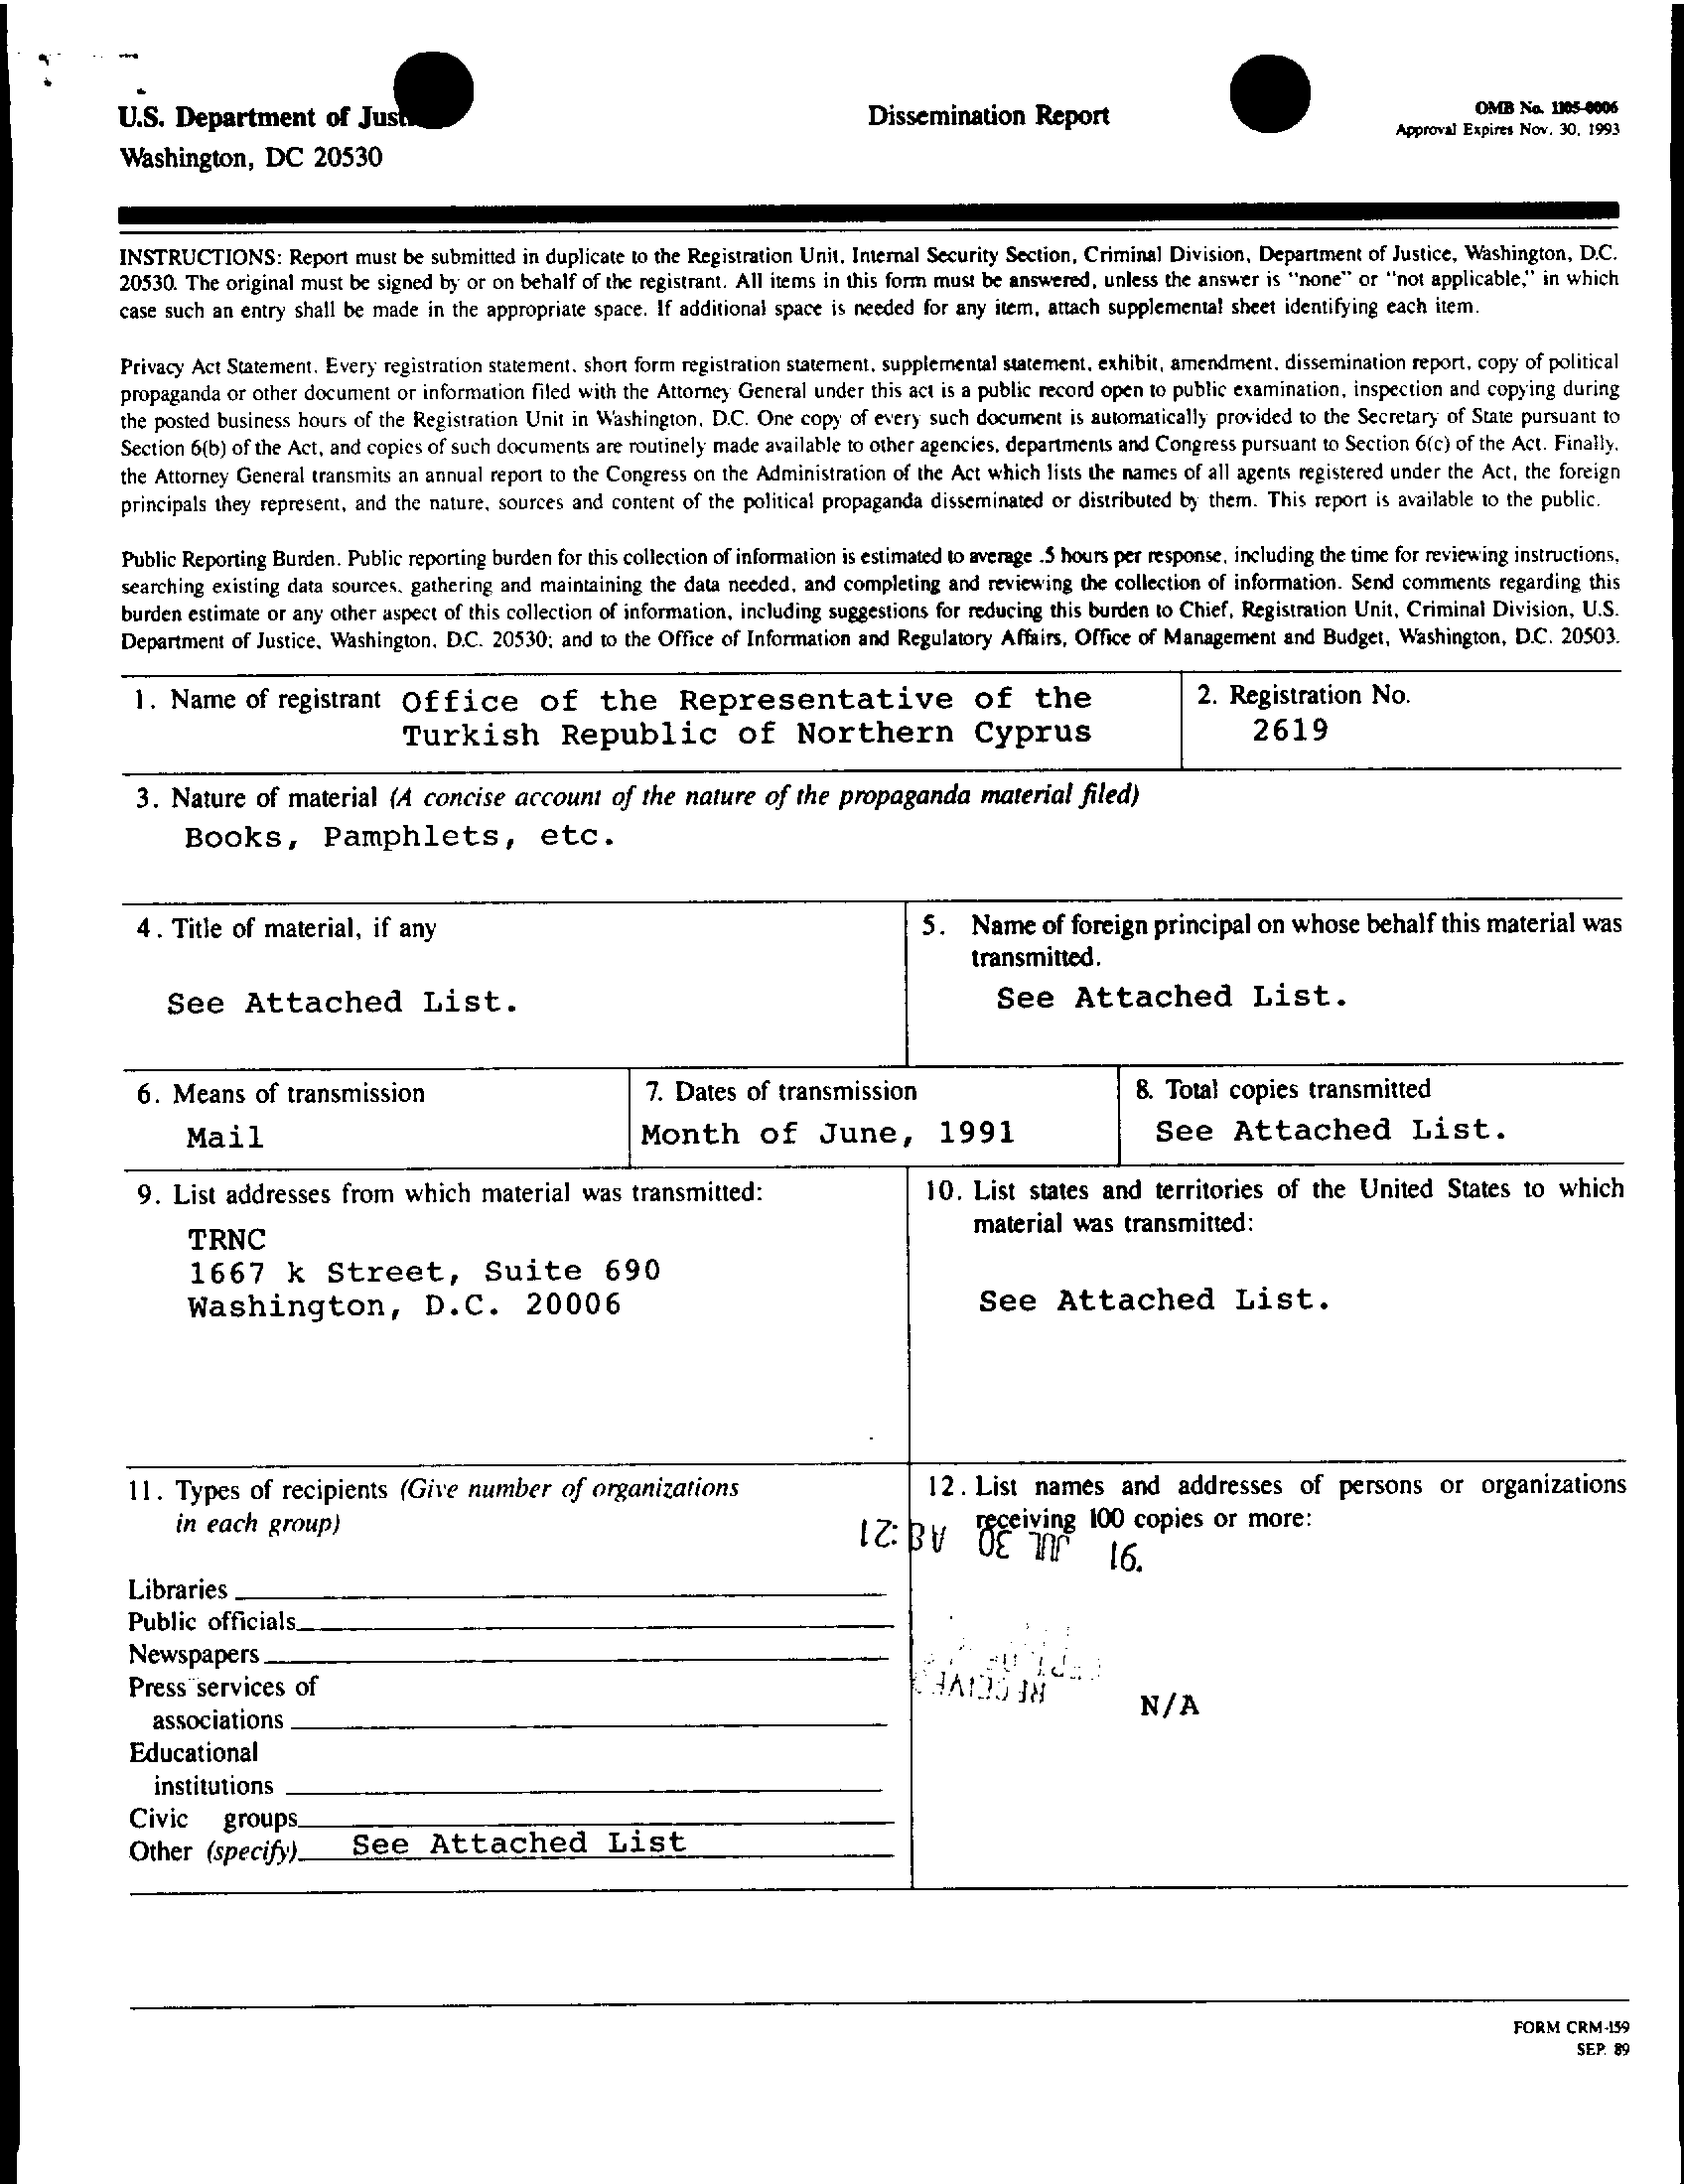

In [14]:
train_dataset_unmapped[2]['images']

In [6]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
     

In [7]:
from datasets.features import ClassLabel

features = train_dataset_unmapped.features
column_names = train_dataset_unmapped.column_names
image_column_name = "images"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"


In [17]:
label_list

['O',
 'B-FILE_DATE',
 'I-FILE_DATE',
 'B-FOREIGN_PRINCIPLE_NAME',
 'I-FOREIGN_PRINCIPLE_NAME',
 'B-REGISTRANT_NAME',
 'I-REGISTRANT_NAME',
 'B-REGISTRATION_NUM',
 'I-REGISTRATION_NUM',
 'B-SIGNER_NAME',
 'I-SIGNER_NAME',
 'B-SIGNER_TITLE',
 'I-SIGNER_TITLE']

In [18]:
id2label

{0: 'O',
 1: 'B-FILE_DATE',
 2: 'I-FILE_DATE',
 3: 'B-FOREIGN_PRINCIPLE_NAME',
 4: 'I-FOREIGN_PRINCIPLE_NAME',
 5: 'B-REGISTRANT_NAME',
 6: 'I-REGISTRANT_NAME',
 7: 'B-REGISTRATION_NUM',
 8: 'I-REGISTRATION_NUM',
 9: 'B-SIGNER_NAME',
 10: 'I-SIGNER_NAME',
 11: 'B-SIGNER_TITLE',
 12: 'I-SIGNER_TITLE'}

In [19]:
def prepare_examples(examples):
    images = examples[image_column_name]
    words = examples[text_column_name]
    boxes = examples[boxes_column_name]
    word_labels = examples[label_column_name]

    # Process the data using the processor
    encoding = processor(
        images,
        words,
        boxes=boxes,
        word_labels=word_labels,
        truncation=True, 
        stride =128,
        padding="max_length",
        max_length=512,
        return_overflowing_tokens=True,
        return_offsets_mapping=True
    )

    # Extract overflow mappings
    offset_mapping = encoding.pop('offset_mapping')
    overflow_to_sample_mapping = encoding.pop('overflow_to_sample_mapping')

    output = {**encoding, "offset_mapping": offset_mapping}
    return output

In [20]:
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
    'offset_mapping': Sequence(feature=Sequence(Value(dtype='int64'))),  # Offset mapping for metrics
})


train_dataset = train_dataset_unmapped.map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
train_dataset.set_format(
    type="torch",
    columns=["pixel_values", "input_ids", "attention_mask", "bbox", "labels"]
)
train_dataset.save_to_disk(fr"{path_extraction_folder}/train.hf")

test_dataset = test_dataset_unmapped.map(
    prepare_examples,
    batched=True,
    batch_size=32,
    remove_columns=column_names,
    features=features,
)
test_dataset.set_format(
    type="torch",
    columns=["pixel_values", "input_ids", "attention_mask", "bbox", "labels"]
)
test_dataset.save_to_disk(fr"{path_extraction_folder}/test.hf")

Map: 100%|███████████████████████████████| 85/85 [00:15<00:00,  5.40 examples/s]
Saving the dataset (1/1 shards): 100%|█| 263/263 [00:00<00:00, 545.42 examples/s


In [8]:
from datasets import load_from_disk

# Reload the datasets
test_dataset = load_from_disk(fr"{path_extraction_folder}/test.hf")
valid_dataset = load_from_disk(fr"{path_extraction_folder_valid}/valid.hf")
train_dataset = load_from_disk(fr"{path_extraction_folder}/train.hf")


In [9]:
# test_dataset = load_from_disk(fr"{path_extraction_folder_test}/test.hf")
valid_dataset.set_format(
    type="torch",
    columns=["pixel_values", "input_ids", "attention_mask", "bbox", "labels"]  # Exclude offset_mapping
)
train_dataset.set_format(
    type="torch",
    columns=["pixel_values", "input_ids", "attention_mask", "bbox", "labels"]  # Exclude offset_mapping
)
test_dataset.set_format(
    type="torch",
    columns=["pixel_values", "input_ids", "attention_mask", "bbox", "labels"]  # Exclude offset_mapping
)

# Optionally, you can print to verify the datasets are loaded correctly

print(valid_dataset)
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels', 'offset_mapping'],
    num_rows: 650
})
Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels', 'offset_mapping'],
    num_rows: 22
})
Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels', 'offset_mapping'],
    num_rows: 263
})


In [23]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels', 'offset_mapping'],
    num_rows: 22
})

In [24]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> Form  DJ - 307\n Radget  Bureau  No.  43 - R226.5\n proval  Expires  Oct.  31 ,  1971\n UNITED  STATES  DEPARTMENT  OF  JUSTICE\n WASHINGTON ,  D.C.  20530\n AMENDMENT  TO  REGISTRATION  STATEMENT\n 1\n Pursuant  to  the  Foreign  Agents\n Registration  Act  of  1938 ,  as  amended .\n !\n 1.  Name  of  Registrant\n 2.  Registration  No.\n OFFICE  OF  TURKISH\n CYPRIOT  COMMUNITY\n 2619\n 3.  This  amendment  is  filed  to  accomplish  the  following  indicated  purpose  or  purposes :\n To  correct  a  deficiency  in\n ☐  To  give  a  10 - day  notice  of  a  change  in  infor-\n mation  as  required  by  Section  2 ( b )  of  the  Act .\n Initial  Statement\n ☑  Supplemental  Statement\n for  April  16 ,  1976\n |  Other  purpose  ( specify )  Change  of  address\n To  give  notice  of  change  in  an\n exhibit  previously  filed .\n 4.  If  this  amendment  requires  the  filing  of  a  document  or  documents ,  please  list-\n ( a )  Article  Chicago  Daily  News ,  Friday , 

In [25]:
train_dataset.set_format("torch")

In [26]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
offset_mapping torch.Size([512, 2])


In [27]:
test_dataset
     

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels', 'offset_mapping'],
    num_rows: 263
})

In [28]:
processor.tokenizer.decode(test_dataset[0]["input_ids"])

"<s> OMB  NO .  1124-0005\n U.S.  Department  of  Justice\n Washington ,  DC  20530\n Short - Form  Registration  Statement\n Pursuant  to  the  Foreign  Agents  Registration\n Act  of  1938 ,  as  amended\n Each  partner ,  officer ,  director ,  associate ,  employee ,  and  agent  of  a  registrant  is  required  to  file  a  short  form  registration  statement  unless  he  engages  in  no\n activities  in  furtherance  of  the  interests  of  the  registrant's  foreign  principal  or  unless  the  services  he  renders  to  the  registrant  are  in  a  secretarial ,  clerical ,  or  in  a\n related  or  similar  capacity .\n Privacy  Act  Statement .  The  filing  of  this  document  is  required  by  the  Foreign  Agents  Registration  Act  of  1938 ,  as  amended ,  22  U.S.C.  §  611  et  seq . ,\n for  the\n purposes  of  registration  under  the  Act  and  public  disclosure .  Provision  of  the  information  requested  is  mandatory ,  and  failure  to  provide  this  infor

In [29]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 Form 0
  -100
 DJ 0
 - 0
 307 0

 -100
 Rad 0
get -100
  -100
 Bureau 0
  -100
 No 0
. -100
  -100
 43 0
 - 0
 R 0
226 -100
. -100
5 -100

 -100
 prov 0
al -100
  -100
 Exp 0
ires -100
  -100
 Oct 0
. -100
  -100
 31 0
 , 0
  -100
 1971 0

 -100
 UNITED 0
  -100
 STATES 0
  -100
 DE 0
PART -100
MENT -100
  -100
 OF 0
  -100
 JUSTICE 0

 -100
 W 0
ASHINGTON -100
 , 0
  -100
 D 0
. -100
C -100
. -100
  -100
 205 0
30 -100

 -100
 AM 0
END -100
MENT -100
  -100
 TO 0
  -100
 REG 0
IS -100
TR -100
ATION -100
  -100
 STAT 0
EMENT -100

 -100
 1 0

 -100
 Purs 0
u -100
ant -100
  -100
 to 0
  -100
 the 0
  -100
 Foreign 0
  -100
 Agents 0

 -100
 Registration 0
  -100
 Act 0
  -100
 of 0
  -100
 1938 0
 , 0
  -100
 as 0
  -100
 amended 0
 . 0

 -100
 ! 0

 -100
 1 0
. -100
  -100
 Name 0
  -100
 of 0
  -100
 Regist 0
rant -100

 -100
 2 0
. -100
  -100
 Registration 0
  -100
 No 0
. -100

 -100
 OFF 5
ICE -100
  -100
 OF 6
  -100
 T 6
UR -100
K -100
ISH -100

 -100
 CY 6
PR -100
I 

In [10]:
import evaluate

# Load the metric using the updated method
metric = evaluate.load("seqeval")


import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

def compute_metrics_with_stride(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Retrieve offset_mapping from eval_dataset
    offset_mapping = trainer.eval_dataset["offset_mapping"]

    true_predictions, true_labels = [], []

    for i, (pred_chunk, label_chunk, offsets) in enumerate(zip(predictions, labels, offset_mapping)):
        non_overlap_indices = [idx for idx, offset in enumerate(offsets) if offset[0] == 0]

        filtered_preds = [pred_chunk[idx] for idx in non_overlap_indices]
        filtered_labels = [label_chunk[idx] for idx in non_overlap_indices]

        chunk_predictions = [
            label_list[p] for (p, l) in zip(filtered_preds, filtered_labels) if l != -100
        ]
        chunk_labels = [
            label_list[l] for (p, l) in zip(filtered_preds, filtered_labels) if l != -100
        ]

        if chunk_predictions and chunk_labels:
            true_predictions.append(chunk_predictions)
            true_labels.append(chunk_labels)

    if not true_predictions or not true_labels:
        print("Warning: No valid predictions or labels found.")
        true_predictions = [[]]
        true_labels = [[]]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [31]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)
     

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=fr"{path_extraction_folder}/test",
    max_steps=1000,
    num_train_epochs=3,
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,  
    learning_rate=3e-5,  # Adjusted learning rate for faster convergence without overshooting
    evaluation_strategy="steps",
    eval_steps=100,  
    load_best_model_at_end=True,  
    metric_for_best_model="f1",  
    weight_decay=0.01,  # Regularization to prevent overfitting 
    warmup_steps=500,  # Warm-up phase for smoother learning rate scaling
    gradient_accumulation_steps=2,  
    save_steps=1000,  
    fp16=True,  # Enable mixed precision training if your GPU supports it
)


/home/gaye/miniconda3/envs/vt2/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
from transformers.data.data_collator import default_data_collator

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics_with_stride,
)

/home/gaye/miniconda3/envs/vt2/lib/python3.11/site-packages/accelerate/accelerator.py:449: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs


In [34]:
trainer.train()

/home/gaye/miniconda3/envs/vt2/lib/python3.11/site-packages/transformers/modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.125830,0.000000,0.000000,0.000000,0.984056
200,No log,0.115415,0.071795,0.024561,0.036601,0.983770
300,No log,0.134938,0.171674,0.070175,0.099626,0.983570
400,No log,0.147276,0.303371,0.047368,0.081942,0.984143
500,0.265800,0.154999,0.314516,0.068421,0.112392,0.984243
600,0.265800,0.143606,0.182109,0.100000,0.129105,0.983943
700,0.265800,0.162957,0.395833,0.066667,0.114114,0.984310
800,0.265800,0.165605,0.397959,0.068421,0.116766,0.984343
900,0.265800,0.167560,0.404255,0.066667,0.114458,0.984336
1000,0.001300,0.171545,0.362319,0.043860,0.078247,0.984183


/home/gaye/miniconda3/envs/vt2/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gaye/miniconda3/envs/vt2/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1000, training_loss=0.13356097608804704, metrics={'train_runtime': 657.2992, 'train_samples_per_second': 24.342, 'train_steps_per_second': 1.521, 'total_flos': 3893383214026752.0, 'train_loss': 0.13356097608804704, 'epoch': 666.6666666666666})

In [35]:
trainer.evaluate()


/home/gaye/miniconda3/envs/vt2/lib/python3.11/site-packages/transformers/modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/home/gaye/miniconda3/envs/vt2/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.17154458165168762,
 'eval_precision': 0.36231884057971014,
 'eval_recall': 0.043859649122807015,
 'eval_f1': 0.0782472613458529,
 'eval_accuracy': 0.9841830108887483,
 'eval_runtime': 12.8728,
 'eval_samples_per_second': 50.494,
 'eval_steps_per_second': 6.37,
 'epoch': 666.6666666666666}

In [11]:

from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(fr"{path_extraction_folder}/test/checkpoint-1000")
model.eval()

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

#### INFERENCE

In [12]:
import torch
import numpy as np

def process_single_example(example, processor, model, stride_size=128, max_length=512):
    """
    Processes a single example from the dataset for inference.
    """
    images = example["images"]
    words = example["tokens"]
    boxes = example["bboxes"]
    word_labels = example["ner_tags"]

    # Ensure input lengths match
    assert len(words) == len(boxes) == len(word_labels), \
        f"Mismatch in input lengths: tokens={len(words)}, bboxes={len(boxes)}, ner_tags={len(word_labels)}"

    encoding = processor(
        images, words, boxes=boxes, word_labels=word_labels, truncation=True, stride=stride_size,
        padding="max_length", max_length=max_length, return_overflowing_tokens=True, return_offsets_mapping=True
    )

    offset_mapping = encoding.pop('offset_mapping')
    overflow_to_sample_mapping = encoding.pop('overflow_to_sample_mapping')

    # Convert pixel values to tensor
    encoding['pixel_values'] = torch.stack([torch.tensor(pv) for pv in encoding['pixel_values']])

    # Convert other items to tensors
    for k, v in encoding.items():
        if isinstance(v, list):
            encoding[k] = torch.tensor(v)
        if k == 'bbox':  # Ensure 'bbox' is LongTensor
            encoding[k] = encoding[k].long()

    return encoding, offset_mapping

def process_predictions(encoding, model, offset_mapping, stride_size=128, width=None, height=None):
    """
    Process predictions from the model output, accounting for stride overlaps 
    and filtering invalid tokens (e.g., labels with -100).
    """
    with torch.no_grad():
        outputs = model(**encoding)
    logits = outputs.logits

    # Convert logits to predictions
    predictions = logits.argmax(-1).tolist()  # Shape: [num_chunks, sequence_length]
    labels = encoding["labels"].tolist()
    token_boxes = encoding["bbox"].tolist()

    true_predictions, true_labels = [], []

    for i, (preds, lbls, offsets) in enumerate(zip(predictions, labels, offset_mapping)):

        # Filter out tokens in the stride overlap
        non_overlap_indices = [idx for idx, offset in enumerate(offsets) if offset[0] == 0]

        if not non_overlap_indices:
            print(f"No valid indices found for chunk {i}, skipping...")
            continue  # Skip if no valid tokens remain

        filtered_preds = [preds[idx] for idx in non_overlap_indices]
        filtered_lbls = [lbls[idx] for idx in non_overlap_indices]

        # Map to label names, excluding ignored labels (-100)
        chunk_predictions = [
            label_list[p] for (p, l) in zip(filtered_preds, filtered_lbls) if l != -100
        ]
        chunk_labels = [
            label_list[l] for (p, l) in zip(filtered_preds, filtered_lbls) if l != -100
        ]

        # Append non-empty predictions and labels
        if chunk_predictions and chunk_labels:
            true_predictions.append(chunk_predictions)
            true_labels.append(chunk_labels)

    # Safeguard: Handle case with no valid predictions
    if not true_predictions or not true_labels:
        print("Warning: No valid predictions or labels found!")
        true_predictions = [[]]
        true_labels = [[]]

    return true_predictions, true_labels


In [13]:
import evaluate
import numpy as np

def process_and_evaluate(true_predictions, true_labels):
    """
    Processes a single example, performs predictions, and computes evaluation metrics.

    Parameters:
        example (dict): A dictionary containing the example data.
        processor: The processor to prepare inputs for the model.
        model: The trained model for inference.
        stride_size (int): The stride size for tokenization.
        max_length (int): The maximum sequence length.

    Returns:
        dict: A dictionary containing predictions, ground truths, and evaluation metrics.
    """
    metric = evaluate.load("seqeval")
    return_entity_level_metrics = False
    
    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [14]:
def run_inference(dataset, processor, model, stride_size=128, max_length=512):
    """
    Processes the entire dataset by running inference for each example.
    """
    all_extractions = []
    results = []

    for example in dataset:
        image = example['images']
        width, height = image.size

        # Process the example
        encoding, offset_mapping = process_single_example(example, processor, model, stride_size, max_length)

        # Get model predictions
        true_predictions, true_labels = process_predictions(
            encoding, model, offset_mapping, stride_size, width, height
        )

        # Compute and collect metrics
        result = process_and_evaluate(true_predictions, true_labels)
        results.append(result)

        # Aggregate metrics
        all_metrics = {
            "precision": np.mean([r["precision"] for r in results]),
            "recall": np.mean([r["recall"] for r in results]),
            "f1": np.mean([r["f1"] for r in results]),
            "accuracy": np.mean([r["accuracy"] for r in results]),
        }

       

    return all_metrics

In [15]:
all_metrics = run_inference(test_dataset_unmapped, processor, model)

/home/gaye/miniconda3/envs/vt2/lib/python3.11/site-packages/transformers/modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/gaye/miniconda3/envs/vt2/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gaye/miniconda3/envs/vt2/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gaye/miniconda3/envs/vt2/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 

In [16]:
all_metrics

{'precision': 0.047058823529411764,
 'recall': 0.025882352941176474,
 'f1': 0.03159663865546218,
 'accuracy': 0.9866301761166439}

In [17]:
import json

# Sample metrics dictionary after calculating with compute_metrics function
all_metrics = {
    "precision": all_metrics["precision"],
    "recall": all_metrics["recall"],
    "f1": all_metrics["f1"],
    "accuracy": all_metrics["accuracy"]
}

# File information and dataset counts
file_info = {
    "num_train_samples": len(dataset_splits['train_split']),
    "num_valid_samples": 100,
    "num_test_samples": len(dataset_splits['test_split']),
}

# Combine metrics, metadata, and predictions/ground truths into a single dictionary
output_data = {
    split_file_name: {
    "metrics": all_metrics,
    "file_info": file_info
    }
    
}

# Save the combined data to a JSON file
output_file_path = (fr"{path_extraction_folder}/model_metrics_with_predictions.json")
with open(output_file_path, "w") as json_file:
    json.dump(output_data, json_file, indent=4, ensure_ascii=False)  # ensure_ascii=False for non-ASCII characters

print(f"Metrics, file info, and predictions saved to {output_file_path}")

Metrics, file info, and predictions saved to layoutlmv3_outputs/deneme-2/FARA-lv3-Short-Form-combined/model_metrics_with_predictions.json


In [18]:
print('Done')

Done
